In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from __future__ import print_function
import numpy
import tensorflow
from tensorflow import keras
from keras.datasets import mnist
from keras import backend as K
from matplotlib import pyplot as plt
import scipy

from pathlib import Path
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

seed = 123
image_height = 192
image_width = 341
images_path = '../images'


def process(image):
    return preprocess_input(image[:, :128, :128])


def output_process(image):
    print(image.shape)
    image = image[:, :128, :128]
    print(image.shape)
    image = tensorflow.cast(image / 255., tensorflow.float32)
    return image


train_ds, test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    images_path,
    label_mode=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="both",
    seed=seed,
    image_size=(image_height, image_width),
    batch_size=64)

train_ds = train_ds.map(lambda x: (process(x), output_process(x)))

test_ds = test_ds.map(lambda x: (process(x), output_process(x)))

Found 4258 files belonging to 1 classes.
Using 3407 files for training.
Using 851 files for validation.
(None, 192, 341, 3)
(None, 128, 128, 3)
(None, 192, 341, 3)
(None, 128, 128, 3)


In [2]:
seed = 123
zoom = 2
downscale_fact = 5.5

image_height_orig = 720
image_width_orig = 1280

image_height_ds = image_height_orig // downscale_fact
image_width_ds = image_width_orig // downscale_fact

image_height = 128
image_width = 128

images_path = '../images'
batch_size = 32

train_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=zoom_range,
    horizontal_flip=True,
    validation_split=0.2,
)

train_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='training',
    # seed=seed,
)

test_ds = train_datagen.flow_from_directory(
    images_path,
    target_size=(image_height_ds, image_width_ds),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode=None,
    subset='validation',
    # seed=seed,
)


def preprocess_img(img):
    y = np.random.randint(0, img.shape[0] - image_height)
    x = np.random.randint(0, img.shape[1] - image_width)
    return img[y:y+image_height, x:x+image_width]


def preprocess_generator(generator):
    while True:
        batch = next(generator)
        batch_crops = np.zeros((batch.shape[0], image_height, image_width, 3))
        out_crops = np.zeros((batch.shape[0], image_height, image_width, 3))
        for i in range(batch.shape[0]):
            img = preprocess_img(batch[i])
            out_crops[i] = img / 255.0
            batch_crops[i] = preprocess_input(img)
        yield batch_crops, out_crops

train_ds_prep = preprocess_generator(train_ds)
test_ds_prep = preprocess_generator(test_ds)

Found 3407 images belonging to 1 classes.
Found 851 images belonging to 1 classes.


In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))
for images, labels in test_ds.take(1):
    for i in range(5):
        # if i == 0:
        #     img = images[i].numpy()
        #     print(f'max: {img.max()}')
        #     print(f'min: {img.min()}')
        #     print(img)
        ax = plt.subplot(5, 1, i + 1)
        plt.imshow((images[i].numpy() + 1) / 2)
        plt.axis("off")

AttributeError: 'DirectoryIterator' object has no attribute 'take'

<Figure size 5000x5000 with 0 Axes>

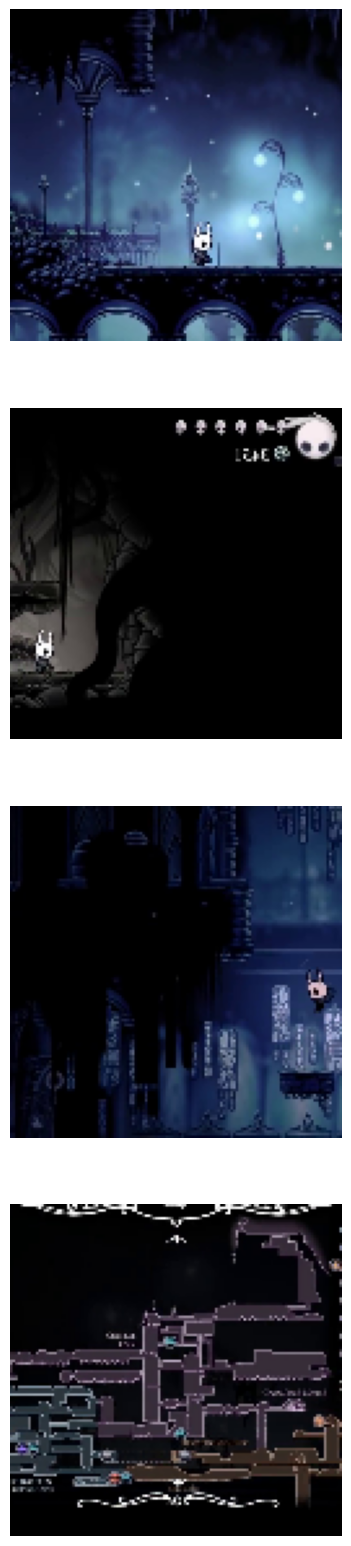

In [8]:
plt.figure(figsize=(25, 25))
images, img_out = next(train_ds_prep)
for i, image in enumerate(img_out[:4]):
    ax = plt.subplot(5, 1, i + 1)
    plt.imshow(image)
    plt.axis("off")

train_ds.reset()

In [44]:

from keras import Sequential
from keras.applications.mobilenet import MobileNet
from keras.layers import Dense, UpSampling2D, Conv2D, LeakyReLU, Conv2DTranspose, ZeroPadding2D, BatchNormalization, \
    Dropout, Activation
from keras.models import Model

def create_improved_baseline_model_4x_comp(image_width=128, image_height=128):
    model = Sequential()
    model.add(Conv2D(48, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
                     padding='same', input_shape=(image_width, image_height, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(96, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(192, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(.2))

    model.add(Conv2D(96, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(name='encoded', dtype='float16'))

    model.add(Conv2DTranspose(192, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(96, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(48, kernel_size=(7, 7), strides=(2, 2), activation='relu', padding='same', kernel_initializer='he_normal'))
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), activation='sigmoid', padding='same', name='decoded'))

    print(("shape of encoded", K.int_shape(model.get_layer('encoded').output)))
    print(("shape of decoded", K.int_shape(model.get_layer('decoded').output)))

    return model


def create_model():
    conv_base = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    model = Sequential(conv_base.layers[:-15])

    # model = Sequential()
    # model.add(Conv2D(48, kernel_size=(7, 7), strides=(2, 2), kernel_initializer='he_normal',
    #                  padding='same', input_shape=(128, 128, 3)))
    # model.add(Activation('relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(.2))
    #
    # model.add(Conv2D(192, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    # model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    # model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))
    # model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), kernel_initializer='he_normal', padding='same'))

    model.add(Conv2DTranspose(512, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(512, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(128, kernel_size=(7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # model.add(Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    # model.add(BatchNormalization())
    # model.add(Activation('relu'))

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2DTranspose(16, kernel_size=(3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same', name='decoded'))

    # x = conv_base.output
    # x = Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding="same")(x)
    # x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding="same")(x)
    # x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding="same")(x)
    # x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(x)
    # x = Conv2DTranspose(32, kernel_size=(3,3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    # x = ZeroPadding2D(((1, 1), (1, 1)))(x)
    # x = Conv2D(8, kernel_size=(3, 3), activation='relu', padding='valid')(x)
    # decoded = Conv2D(3, kernel_size=(5, 5), activation='sigmoid', padding='same')(x)

    # Specify model
    # model = Model(inputs=conv_base.input, outputs=decoded)
    # model.summary()
    return model, conv_base

# create_model()[1].summary()
create_model()[0].summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 64, 64, 32)      

In [46]:
import tensorflow


def ssim_loss(y_true, y_pred):
    # print(f'y_true: {y_true}')
    # print(f'y_pred: {y_pred}')
    return 1 - tensorflow.reduce_mean(tensorflow.image.ssim_multiscale(y_true, y_pred, 1.0, filter_size=3))


model, conv_base = create_model()
# model = create_improved_baseline_model_4x_comp()

# total_num_layers = len(model.layers)
# num_base_layers = len(conv_base.layers)
# print(f"Total number of layers is {total_num_layers}")
# print(f"Number of pretrained base layers is {num_base_layers}")
#
#
conv_base.trainable = False
# for layer in model.layers:
#     layer.trainable = False

# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss=tensorflow.keras.losses.MeanAbsoluteError())
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=ssim_loss)

# Train model for 10 epochs
model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=3,
                verbose=1)

Epoch 1/3
106/106 [==============================] - 47s 395ms/step - loss: 0.4634 - val_loss: 0.4842
Epoch 2/3
106/106 [==============================] - 40s 378ms/step - loss: 0.3784 - val_loss: 0.3828
Epoch 3/3
106/106 [==============================] - 41s 386ms/step - loss: 0.3391 - val_loss: 0.3390


In [51]:
# for layer in model.layers[:num_base_layers]:
#     layer.trainable=True

conv_base.trainable = False

model.fit(train_ds_prep,
                validation_data = test_ds_prep,
                steps_per_epoch = train_ds.n // train_ds.batch_size,
                validation_steps = test_ds.n // test_ds.batch_size,
                epochs=15,
                verbose=1)

Epoch 1/15
106/106 [==============================] - 41s 389ms/step - loss: 0.2286 - val_loss: 0.2474
Epoch 2/15
106/106 [==============================] - 40s 383ms/step - loss: 0.2262 - val_loss: 0.2510
Epoch 3/15
106/106 [==============================] - 40s 375ms/step - loss: 0.2250 - val_loss: 0.2509
Epoch 4/15
106/106 [==============================] - 40s 377ms/step - loss: 0.2237 - val_loss: 0.2573
Epoch 5/15
106/106 [==============================] - 40s 380ms/step - loss: 0.2221 - val_loss: 0.2571
Epoch 6/15
106/106 [==============================] - 40s 380ms/step - loss: 0.2224 - val_loss: 0.2503
Epoch 7/15
106/106 [==============================] - 40s 382ms/step - loss: 0.2208 - val_loss: 0.2437
Epoch 8/15
106/106 [==============================] - 40s 383ms/step - loss: 0.2188 - val_loss: 0.2457
Epoch 9/15
106/106 [==============================] - 40s 383ms/step - loss: 0.2159 - val_loss: 0.2410
Epoch 10/15
106/106 [==============================] - 41s 387ms/step - l

Epoch 1/3
106/106 [==============================] - 39s 371ms/step - loss: 0.0921 - val_loss: 0.1045
Epoch 2/3
106/106 [==============================] - 42s 397ms/step - loss: 0.0909 - val_loss: 0.1039
Epoch 3/3
106/106 [==============================] - 42s 400ms/step - loss: 0.0882 - val_loss: 0.1025

In [54]:
model.save('../model-saves/pretrained/')

INFO:tensorflow:Assets written to: ../model-saves/pretrained/assets


INFO:tensorflow:Assets written to: ../model-saves/pretrained/assets


1/1 [==============================] - 0s 30ms/step


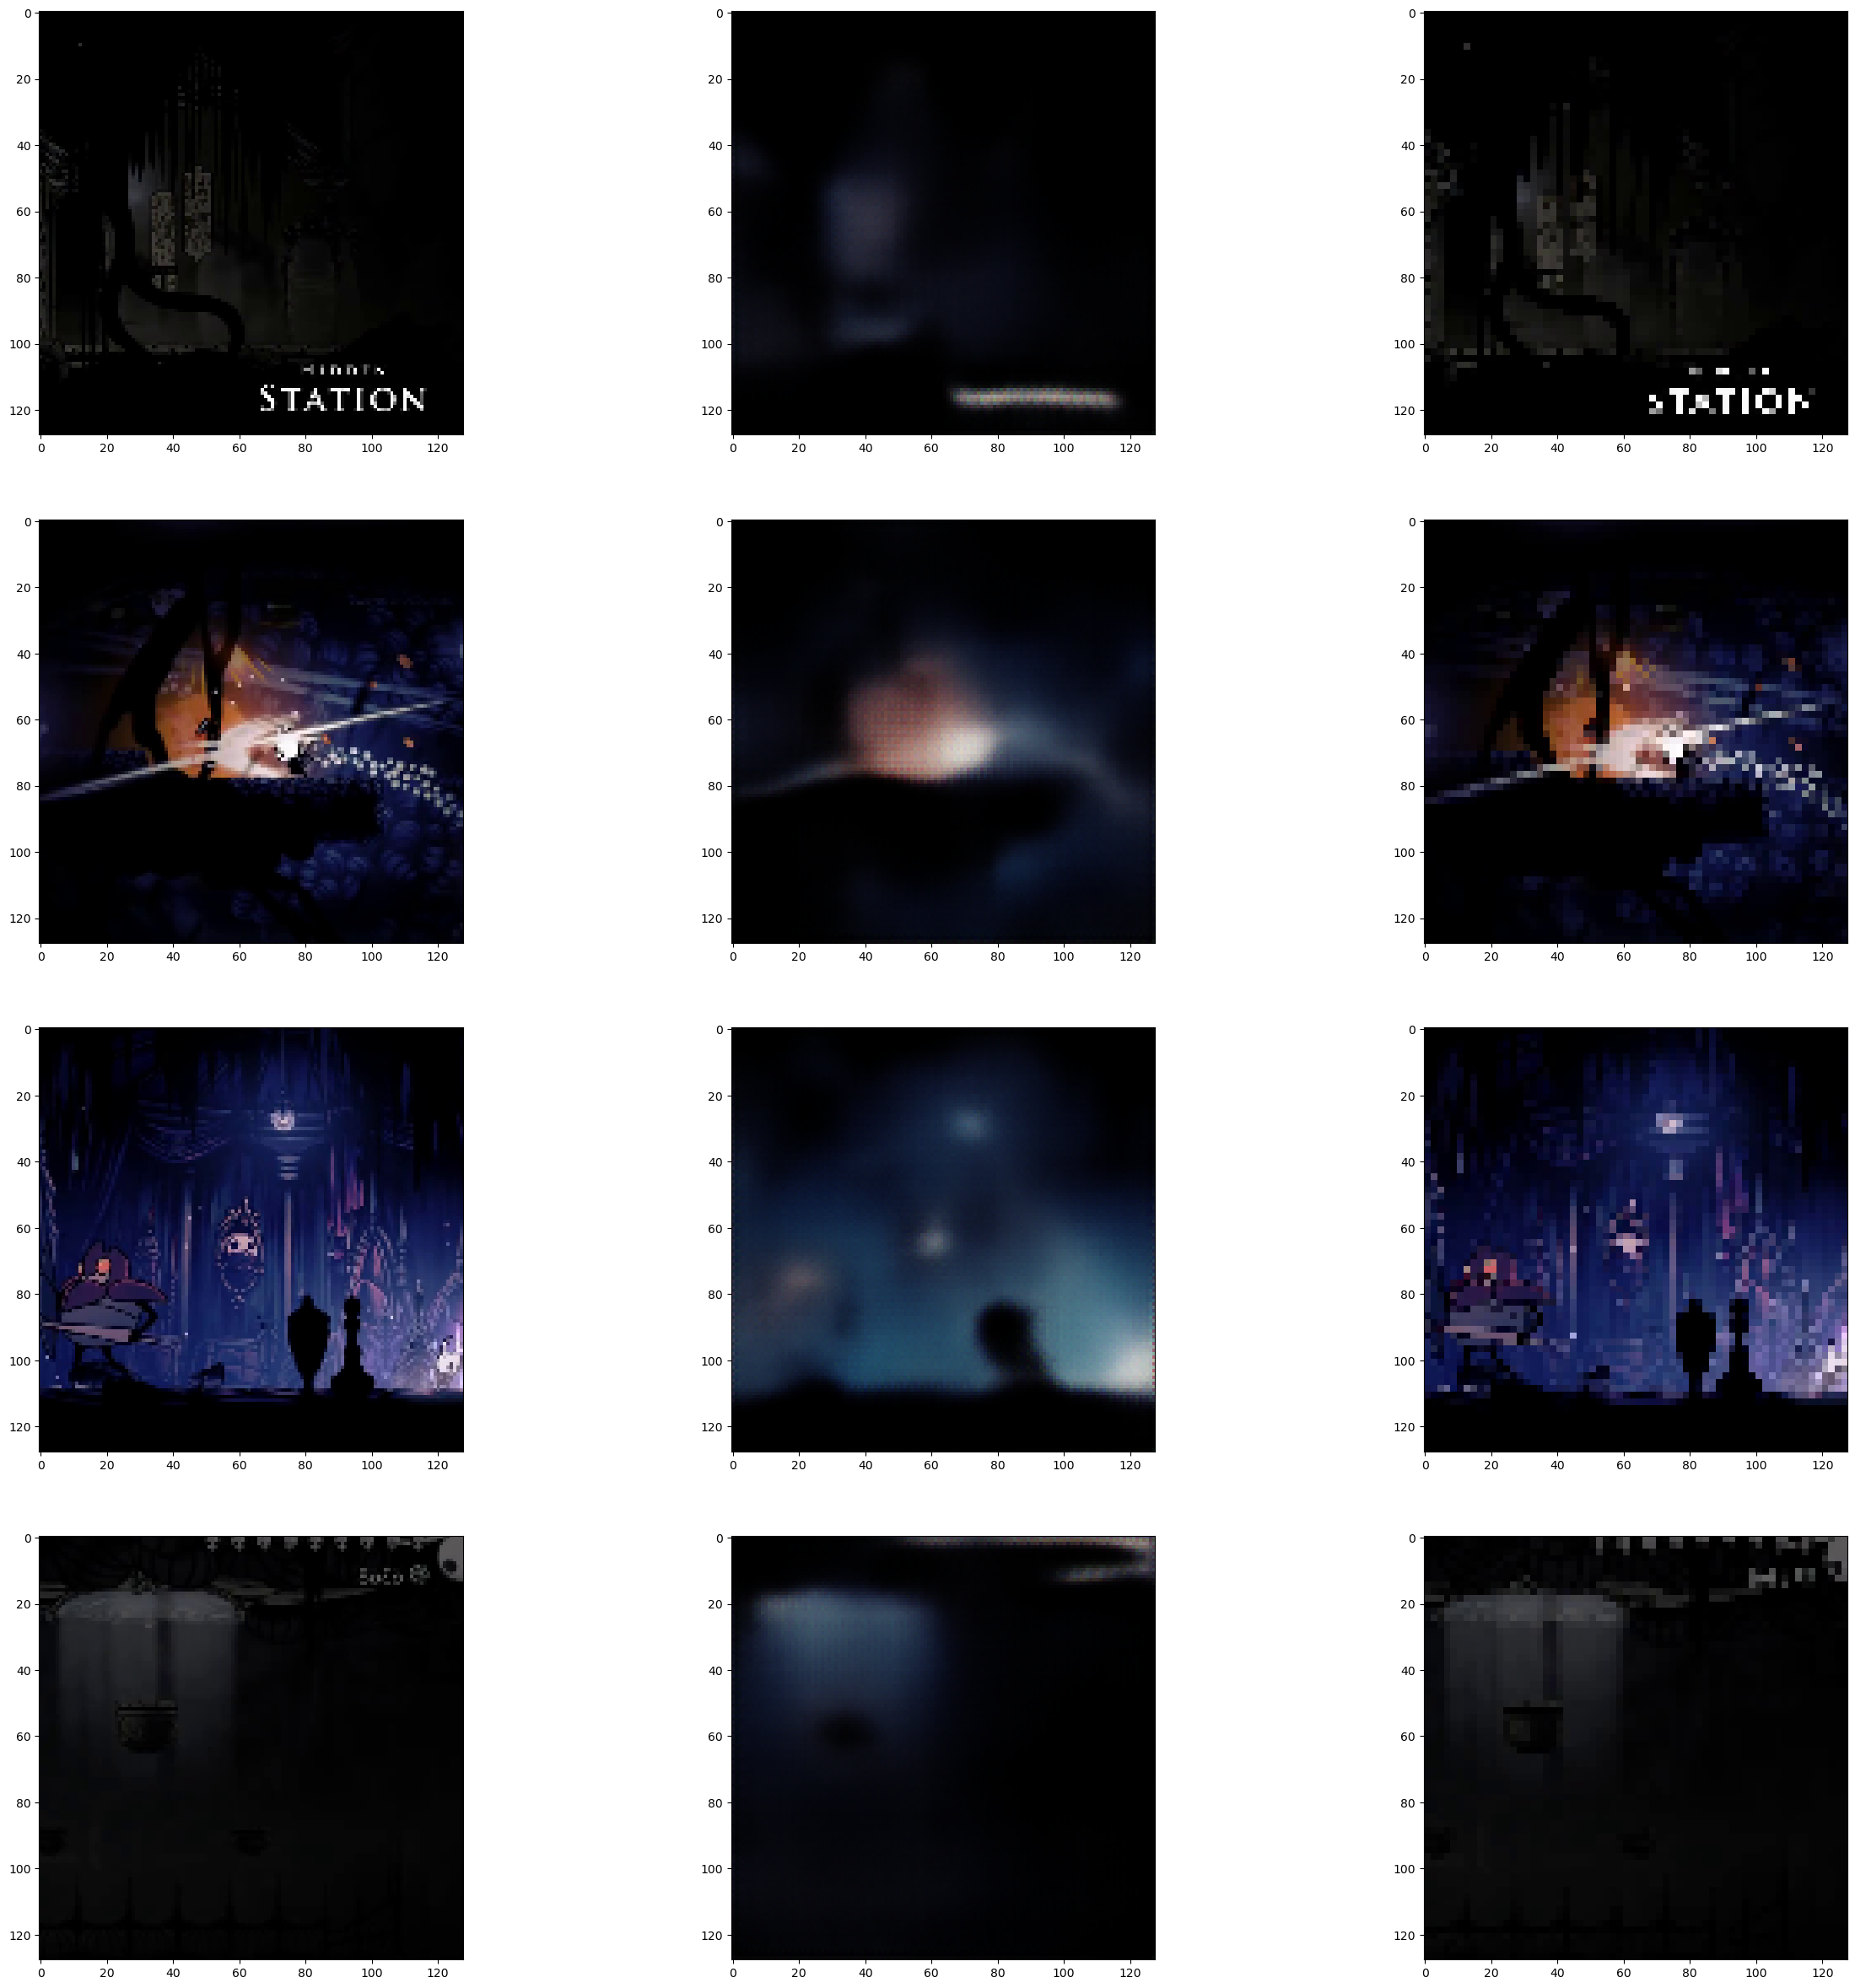

In [52]:
img_number = 4
images_in, images_out = next(train_ds_prep)
test_images = images_in[:img_number]
decoded_imgs = model.predict(test_images)

fig = plt.figure(figsize=(30, 30))

for i, in_img, out_img in zip(range(0, img_number, 1), test_images, decoded_imgs):
    in_img = (in_img + 1) / 2
    plt.subplot(img_number, 3, i * 3 + 1)
    plt.imshow(in_img)
    plt.subplot(img_number, 3, i * 3 + 2)
    plt.imshow(out_img)
    plt.subplot(img_number, 3, i * 3 + 3)
    manual_compression = in_img[::2, ::2]
    manual_compression = manual_compression.repeat(2, axis=0).repeat(2, axis=1)
    # manual_compression = tensorflow.cast(in_img*255. ,tensorflow.int32)
    # manual_compression = manual_compression - (manual_compression % 64)
    # manual_compression = tensorflow.cast(manual_compression ,tensorflow.float32)
    # manual_compression = tensorflow.cast(manual_compression/255. ,tensorflow.float32)
    plt.imshow(manual_compression)

In [100]:
imagenet = MobileNet(weights='imagenet', include_top=True, input_shape=(128, 128, 3))
predicted = imagenet.predict(train_ds)
predicted[0]

17/17 [==============================] - 4s 169ms/step


array([8.93921481e-07, 6.18394042e-05, 1.66767877e-05, 6.17754768e-06,
       1.30565388e-06, 1.03351951e-04, 1.14254726e-06, 1.34261870e-06,
       5.06379422e-07, 1.98337348e-05, 3.68101567e-08, 4.92656341e-07,
       9.38326536e-07, 1.07006095e-07, 9.67947813e-07, 3.65947386e-07,
       3.83407183e-07, 5.44954553e-08, 1.17475520e-06, 2.94718802e-07,
       1.08620986e-06, 3.55900028e-07, 1.21880305e-07, 4.76434053e-07,
       1.82085742e-08, 3.44347683e-07, 1.09151997e-05, 5.76872935e-07,
       5.98721272e-07, 3.93078744e-06, 3.34309407e-05, 7.24148265e-07,
       2.64159553e-05, 4.65159474e-06, 1.50089647e-06, 7.48694390e-07,
       4.40862959e-06, 6.79250931e-08, 6.17191134e-08, 1.65046674e-06,
       8.10972415e-06, 1.57918623e-06, 5.08342666e-08, 1.53855154e-07,
       9.35572587e-07, 1.80564442e-07, 7.12239057e-07, 6.82769814e-06,
       2.97654879e-06, 3.42841872e-06, 6.13787370e-06, 3.47678506e-05,
       2.03978198e-05, 6.80561129e-07, 1.34983270e-06, 6.01621832e-06,
      